# ASTR8004 Astronomical Computing Assignment 3

## 1 git in Practice

The link to the public github repository for the assignment: <https://github.com/kitty-anu/astro_comp>

## 2 Using ADQL to Search for Bright Stars Around the Open Cluster M67
### 2.1 Task
A colleague is interested in the open cluster Messier 67 (RA = 132.825 deg, Dec = 11.8 deg) and is considering an observation proposal using the 2dF fibre positioner and HERMES spectrograph (effective for Gaia G band magnitudes < 14). They need to know if there are enough bright stars in this region for observation. Your task is to assist by querying data from Gaia DR3 and performing some basic analysis.
* Download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the `"""query"""` notation)

In [1]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Part 1: Defining the ADQL query
query = """
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, 
       gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag,
       gaia.phot_bp_rp_excess_factor, tmass.j_m, tmass.ks_m, tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation
WHERE 1=CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), CIRCLE('ICRS', 132.825, 11.8, 1))
AND gaia.phot_g_mean_mag < 14
"""
# Launching the query to the Gaia archive
job = Gaia.launch_job(query)
result = job.get_results()

* Determine how many stars are returned from the initial query.

In [3]:
# Part 2: Printing the result count
print(f"Number of stars found: {len(result)}")

Number of stars found: 1018


* Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’.

In [4]:
# Part 3: Identifying  stars with bad 2MASS photometry (ph_qual not 'AAA')
bad_photometry_stars = result[result['ph_qual'] != 'AAA']

# Printing the number of stars with bad photometry
print(f"Number of stars with bad 2MASS photometry: {len(bad_photometry_stars)}")

Number of stars with bad 2MASS photometry: 21


* Identify any stars with negative (or non-positive) parallaxes in the Gaia data.

In [5]:
# Step 4: Identifying stars with negative or non-positive parallaxes
bad_parallax_stars = result[result['parallax'] <= 0]

# Printing the number of stars with bad parallaxes
print(f"Number of stars with negative or non-positive parallaxes: {len(bad_parallax_stars)}")

Number of stars with negative or non-positive parallaxes: 2


* Apply these two quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes). After applying the cuts, determine how many stars remain.

In [6]:
# Part 5: Applying quality cuts (remove stars with bad 2MASS photometry and non-positive parallaxes)
good_stars = result[(result['ph_qual'] == 'AAA') & (result['parallax'] > 0)]

# Printing the number of stars that remain after the cuts
print(f"Number of stars remaining after quality cuts: {len(good_stars)}")

Number of stars remaining after quality cuts: 988


* Using the remaining stars, generate a figure with two panels (1 point per panel):
    1. A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.
    2. A 2MASS J-Ks vs. apparent K magnitude diagram.
* Save the figure as figures/cmds M67.png with a resolution of 200 dots per inch.

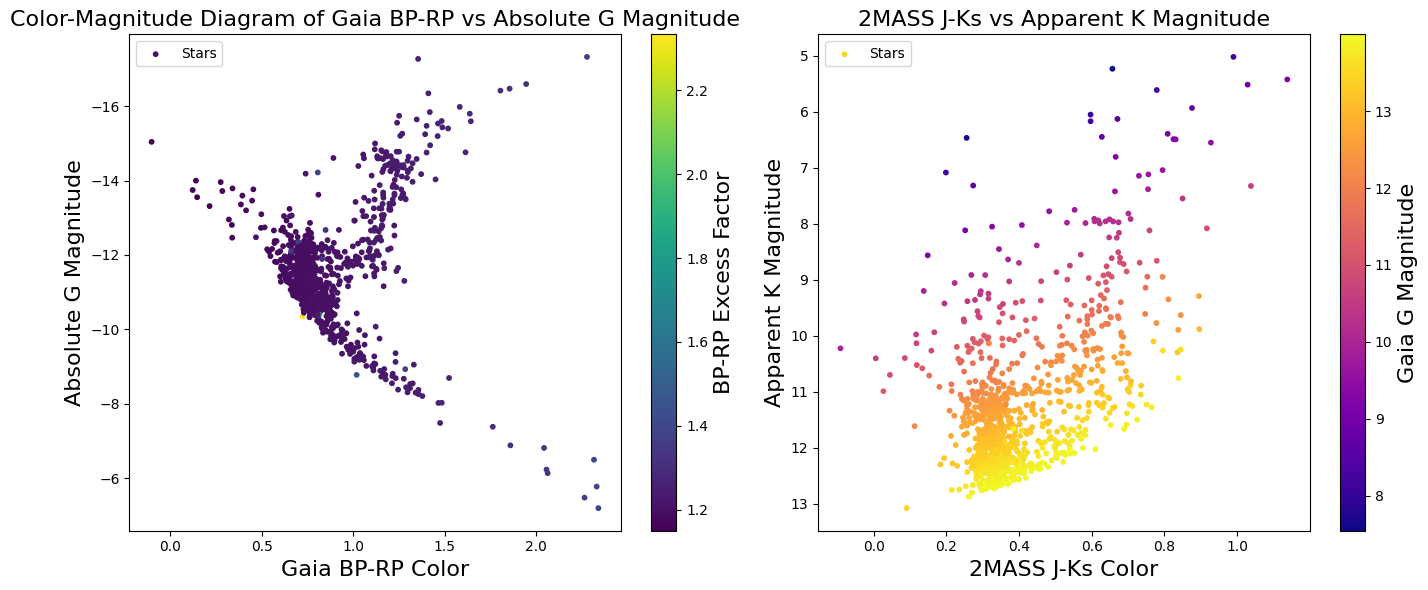

In [7]:
# Part 6: Generating the plots with color mapping

# Converting parallax from milliarcseconds to arcseconds
parallax_arcsec = good_stars['parallax'] / 1000.0

# (a) Color-Magnitude Diagram (CMD)
bp_rp = good_stars['phot_bp_mean_mag'] - good_stars['phot_rp_mean_mag']  # Gaia BP-RP color
G = good_stars['phot_g_mean_mag']  # Gaia G magnitude
M_G = G + 5 * np.log10(parallax_arcsec) - 10  # Absolute G magnitude

# (b) 2MASS J-Ks vs Apparent Ks Magnitude
J = good_stars['j_m']  # 2MASS J magnitude
Ks = good_stars['ks_m']  # 2MASS Ks magnitude
J_Ks = J - Ks  # 2MASS J-Ks color

# Creating the figure with two panels
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# (a) CMD: BP-RP vs. Absolute G magnitude, colored by BP-RP Excess Factor
sc1 = ax[0].scatter(
    bp_rp, 
    M_G, 
    s=10, 
    c=good_stars['phot_bp_rp_excess_factor'],  # Color by BP-RP excess factor
    cmap='viridis', 
    label='Stars'
)
ax[0].invert_yaxis()  # Inverting y-axis for CMD
ax[0].set_xlabel('Gaia BP-RP Color', fontsize=16)
ax[0].set_ylabel('Absolute G Magnitude', fontsize=16)
ax[0].set_title('Color-Magnitude Diagram of Gaia BP-RP vs Absolute G Magnitude', fontsize=16)
ax[0].legend()

# Adding color bar for CMD
cbar1 = plt.colorbar(sc1, ax=ax[0])
cbar1.set_label('BP-RP Excess Factor', fontsize=16)

# (b) J-Ks vs. Apparent Ks magnitude, colored by Gaia G magnitude
sc2 = ax[1].scatter(
    J_Ks, 
    Ks, 
    s=10, 
    c=good_stars['phot_g_mean_mag'],  # Color by Gaia G magnitude
    cmap='plasma', 
    label='Stars'
)
ax[1].invert_yaxis()  # Inverting y-axis for apparent magnitude plot
ax[1].set_xlabel('2MASS J-Ks Color', fontsize=16)
ax[1].set_ylabel('Apparent K Magnitude', fontsize=16)
ax[1].set_title('2MASS J-Ks vs Apparent K Magnitude', fontsize=16)
ax[1].legend()

# Adding color bar for J-Ks plot
cbar2 = plt.colorbar(sc2, ax=ax[1])
cbar2.set_label('Gaia G Magnitude', fontsize=16)

# Part 7: Save the figure as 'figures/cmds_M67.png' with 200 dpi resolution

# Ensuring the directory exists
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Path to save the figure
output_path = os.path.join(output_dir, "cmds_M67.png")

# Saving the figure before showing it
plt.tight_layout()
plt.savefig(output_path, dpi=200)
plt.show()
plt.close()

* Give your colleague a recommendation for the potential proposal when only judging the fibre usage.

After analyzing the star population around Messier 67 within a 1-degree radius, I have identified stars with Gaia G-band magnitudes < 14, which are suitable for observation with the 2dF fibre positioner and HERMES spectrograph. After making the quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes), we were left with 988 stars. These stars are bright enough and have good quality data for observation. The Color-Magnitude Diagram (CMD) of Gaia BP-RP vs. Absolute G magnitude shows a range of bright stars that are likely to provide useful spectroscopic data. The 2MASS J-Ks vs. Apparent K magnitude diagram further supports the presence of well-measured stars in this region. 

Given the abundance of stars that meet the brightness criterion, I recommend proceeding with the observation proposal, as there are sufficient stars available for optimal fibre usage with the 2dF system. However, it would be worth considering any additional constraints (such as sky coverage or stellar types) based on the scientific objectives of the proposal.

## 3 The radial metallicity relation in simulated data
### 3.1 Background
The radial metallicity relation is a function that describes the change of metallicity - here the gas phase metallicity $A(O) = log10(NO/NH) + 12$ - along the galactocentric radius $R_\text{Gal.}$. Understanding the radial metallicity gradient in galaxies provides critical insights into their formation and evolutionary processes, such as inside-out formation, gas accretion, outflows, and radial migration. A lot of work has been done through observational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simulations (e.g. Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand the radial metallicity gradient! <br>
Your colleague has just finished an exciting cosmological simulation that traces the gas phase metallicity for a Milky Way analogue, that is, a spiral galaxy. They have limited the simulation data to the positions (x, y, z) of the innermost gas particles($R_\text{Gal.}< 25 \text{kpc}$) and their gas phase metallicity $A(O)$ and uploaded them as a FITS file for you here: https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits

### 3.2 Task
Download the file from the link above into `data/`. Load the file with python and then perform the following tasks to create figures that are saved in `figures/`:
* Plot a 2-panel figure:
    - Logarithmic density plot of $R_\text{Gal.}$ vs. $A(O)$, with a linear fit and legend.
    - Residuals of the fit, $R_\text{Gal.}$ vs. $\Delta A(O)$.

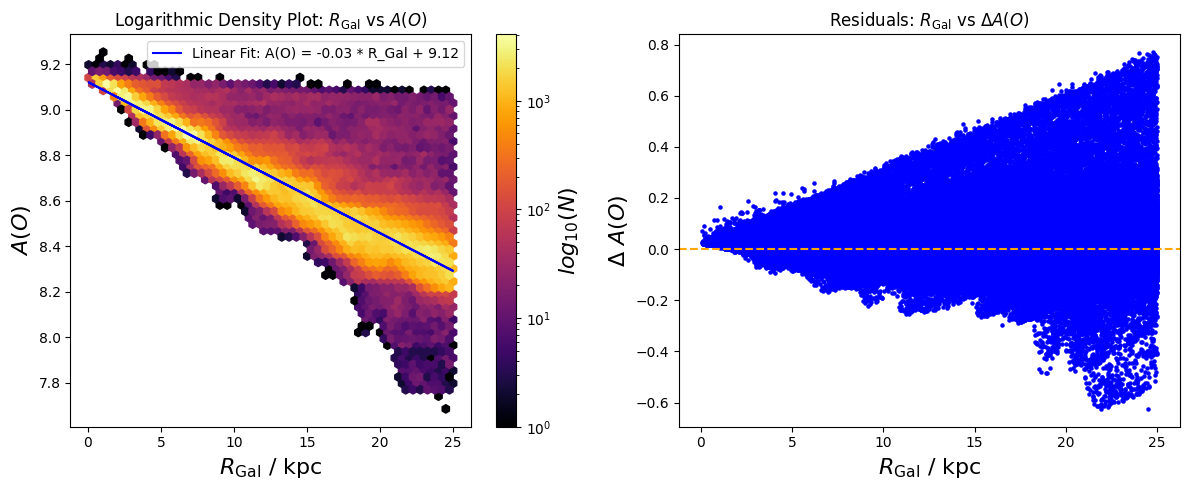

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Part 1: Plotting a 2-panel figure

# File path and URL
file_path = 'data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'
file_url = 'https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'
# Checking if the file exists, else downloading it
if not os.path.exists(file_path):
    try:
        import wget
        print(f"Downloading file from {file_url}...")
        wget.download(file_url, out=file_path)
        print("\nDownload complete.")
    except Exception as e:
        raise RuntimeError(f"Could not download FITS file: {e}")

# Loading the FITS file
with fits.open(file_path) as hdul:
    data = hdul[1].data
    x = data['x']
    y = data['y']
    z = data['z']
    A_O = data['A_O']  # Gas phase metallicity A(O)

# Calculating galactocentric radius RGal
R_Gal = np.sqrt(x**2 + y**2 + z**2)

# Performing the linear fit (without using fitting tools)
n = len(R_Gal)
sum_R_A = np.sum(R_Gal * A_O)
sum_R = np.sum(R_Gal)
sum_A = np.sum(A_O)
sum_R_sq = np.sum(R_Gal**2)

# Computing slope (m) and intercept (b)
m = (n * sum_R_A - sum_R * sum_A) / (n * sum_R_sq - sum_R**2)
b = (sum_A - m * sum_R) / n

# # Calculating residuals (ΔA(O) = observed A(O) - fitted A(O))
A_O_fit = m * R_Gal + b
A_O_residuals = A_O - A_O_fit

# Creating the 2-panel plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# (a) Logarithmic density plot of RGal vs A(O)
hb = ax[0].hexbin(R_Gal, A_O, gridsize=50, cmap='inferno', bins='log')
ax[0].plot(R_Gal, A_O_fit, color='blue', label=f'Linear Fit: A(O) = {m:.2f} * R_Gal + {b:.2f}')
ax[0].set_xlabel(r'$R_\mathrm{Gal} ~/~\mathrm{kpc}$', fontsize=16)
ax[0].set_ylabel(r'$A(O)$', fontsize=16)
ax[0].set_title(r'Logarithmic Density Plot: $R_\mathrm{Gal}~\mathrm{vs}~A(O)$')
ax[0].legend()

cb = fig.colorbar(hb, ax=ax[0])
cb.set_label(r'$log_{10}(N)$', size = 16)

# (b) Residuals plot: RGal vs ΔA(O)
ax[1].scatter(R_Gal, A_O_residuals, s=5, color='blue')
ax[1].axhline(0, color='orange', linestyle='--')
ax[1].set_xlabel(r'$R_\mathrm{Gal} ~/~\mathrm{kpc}$', fontsize=16)
ax[1].set_ylabel(r'$\Delta~A(O)$', fontsize=16)
ax[1].set_title(r'Residuals: $R_\mathrm{Gal}~\mathrm{vs}~ΔA(O)$')

# Saving the figure
output_dir = "figures"
output_file = "figures/radial_metallicity_relation.png"

# Ensuring the directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.tight_layout()
plt.savefig(output_file, dpi=200)
plt.show()
plt.close()

* Use a python fitting tool to fit a linear function to the data, reporting the intercept and slope with uncertainties. Include any hyperparameters used.

In [9]:
from scipy.optimize import curve_fit

# Step 1: Define a linear model
def linear_model(R_Gal, m, b):
    return m * R_Gal + b

# Step 2: Use curve_fit to fit the data
popt, pcov = curve_fit(linear_model, R_Gal, A_O)

# popt contains the optimal values for slope (m) and intercept (b)
m_opt, b_opt = popt

# pcov is the covariance matrix, and the uncertainties are the square root of the diagonal elements
m_err, b_err = np.sqrt(np.diag(pcov))

# Step 3: Print the results with uncertainties
print(f"Slope (m): {m_opt:.4f} ± {m_err:.4f}")
print(f"Intercept (b): {b_opt:.4f} ± {b_err:.4f}")

Slope (m): -0.0333 ± 0.0000
Intercept (b): 9.1223 ± 0.0003


* Discuss where the linear model fits well and where it does not. Use statistical metrics, such as the root mean squares or other goodness-of-fit indicators, to quantify the performance of your linear fit in general and regions with larger residuals.

The linear model fits well at smaller galactocentric radii ($R_{\text{Gal}} \approx 0$ to $10 \, \text{kpc}$). In these regions, the residuals (the difference between the observed and predicted values) are small, indicating that the model captures the trend effectively.

At larger radii ($R_{\text{Gal}} > 15 \, \text{kpc}$), the linear model shows larger residuals, suggesting that the assumption of a purely linear relationship does not hold. This could be due to more complex physical processes which the simple linear model does not account for.

#### Using Statistical Metrics:

To evaluate the goodness of fit, we calculate the following:

##### **Root Mean Square Error (RMSE)**:
This metric gives the average magnitude of the residuals, essentially measuring how well the linear model predicts the data. 

$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( A(O)_i - \hat{A(O)}_i \right)^2 }$

Where:
- $A(O)_i$ is the observed metallicity,
- $\hat{A(O)}_i$ is the predicted metallicity from the linear model,
- $n$ is the total number of data points.

Performing this calculation using the steps:
1. Compute the residuals: $\text{residual}_i = A(O)_i - \hat{A(O)}_i$,
2. Square each residual,
3. Take the mean of the squared residuals,
4. Take the square root of this mean.

$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \text{residual}_i^2}$

##### **Coefficient of Determination ($R^2$)**:
The $R^2$ value indicates how much of the variance in $A(O)$ is explained by the model. An $R^2$ value close to 1 means the model explains most of the variation, while a lower value indicates poor performance.

$R^2 = 1 - \frac{\sum (A(O)_i - \hat{A(O)}_i)^2}{\sum (A(O)_i - \bar{A(O)})^2}$

Where:
- $ \sum (A(O)_i - \hat{A(O)}_i)^2 $ is the residual sum of squares (RSS),
- $ \sum (A(O)_i - \bar{A(O)})^2 $ is the total sum of squares (TSS), and
- $ \bar{A(O)} $ is the mean value of $A(O)$.

To calculate $R^2$:
1. Calculate the residual sum of squares (RSS): $ \text{RSS} = \sum (A(O)_i - \hat{A(O)}_i)^2 $,
2. Calculate the total sum of squares (TSS): $ \text{TSS} = \sum (A(O)_i - \bar{A(O)})^2 $,
3. Compute $R^2$:

$R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}$

In [10]:
# Calculating the Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(A_O_residuals**2))

# Calculating the R-squared (R²)
ss_total = np.sum((A_O - np.mean(A_O))**2)  # Total sum of squares
ss_residual = np.sum(A_O_residuals**2)      # Residual sum of squares
r2 = 1 - (ss_residual / ss_total)

# Reporting the results
print(f"Goodness-of-Fit Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Identifying regions with large residuals
# Here I have considered large residuals as those larger than 2 times the RMSE
large_residuals_mask = np.abs(A_O_residuals) > 2 * rmse
large_residuals = R_Gal[large_residuals_mask]

# Reporting regions with large residuals
print(f"\nRegions with large residuals (|Residual| > 2*RMSE):")
for r in large_residuals:
    print(f"R_Gal: {r:.2f} kpc")

Goodness-of-Fit Metrics:
Root Mean Square Error (RMSE): 0.0876
R-squared (R²): 0.8729

Regions with large residuals (|Residual| > 2*RMSE):
R_Gal: 19.54 kpc
R_Gal: 21.94 kpc
R_Gal: 22.75 kpc
R_Gal: 18.30 kpc
R_Gal: 22.86 kpc
R_Gal: 20.37 kpc
R_Gal: 16.09 kpc
R_Gal: 22.45 kpc
R_Gal: 18.63 kpc
R_Gal: 24.25 kpc
R_Gal: 18.08 kpc
R_Gal: 19.02 kpc
R_Gal: 15.68 kpc
R_Gal: 22.59 kpc
R_Gal: 17.02 kpc
R_Gal: 22.47 kpc
R_Gal: 23.05 kpc
R_Gal: 14.92 kpc
R_Gal: 22.46 kpc
R_Gal: 22.59 kpc
R_Gal: 20.57 kpc
R_Gal: 20.33 kpc
R_Gal: 21.55 kpc
R_Gal: 19.15 kpc
R_Gal: 24.03 kpc
R_Gal: 15.80 kpc
R_Gal: 19.40 kpc
R_Gal: 18.77 kpc
R_Gal: 19.92 kpc
R_Gal: 18.10 kpc
R_Gal: 22.18 kpc
R_Gal: 22.02 kpc
R_Gal: 18.34 kpc
R_Gal: 24.39 kpc
R_Gal: 17.69 kpc
R_Gal: 18.23 kpc
R_Gal: 18.42 kpc
R_Gal: 16.75 kpc
R_Gal: 17.54 kpc
R_Gal: 19.72 kpc
R_Gal: 15.04 kpc
R_Gal: 20.86 kpc
R_Gal: 24.50 kpc
R_Gal: 24.46 kpc
R_Gal: 19.64 kpc
R_Gal: 18.02 kpc
R_Gal: 24.21 kpc
R_Gal: 24.82 kpc
R_Gal: 19.33 kpc
R_Gal: 18.74 kpc
R_Gal: 9.61

In regions where $R_{\text{Gal}} > 15 \, \text{kpc}$, the residuals become notably larger. This suggests that the linear model is unable to capture the full complexity of the radial metallicity gradient in these outer regions.

#### Conclusion
While the linear model provides a reasonable fit in the inner regions of the galaxy, it fails to accurately model the outer regions beyond $R_{\text{Gal}} > 15 \, \text{kpc}$. This is reflected in the larger residuals in these regions, as well as the overall RMSE and $R^2$ values, which suggest the linear fit is not entirely adequate for capturing the radial metallicity trend.

* Plot a 3-panel figure for the x vs. y plane using the same bins and sensible colormaps:
    - 2D-histogram of the median simulated A(O).
    - 2D-histogram of the median fitted A(O)
    - 2D-histogram of the median residuals ∆A(O).

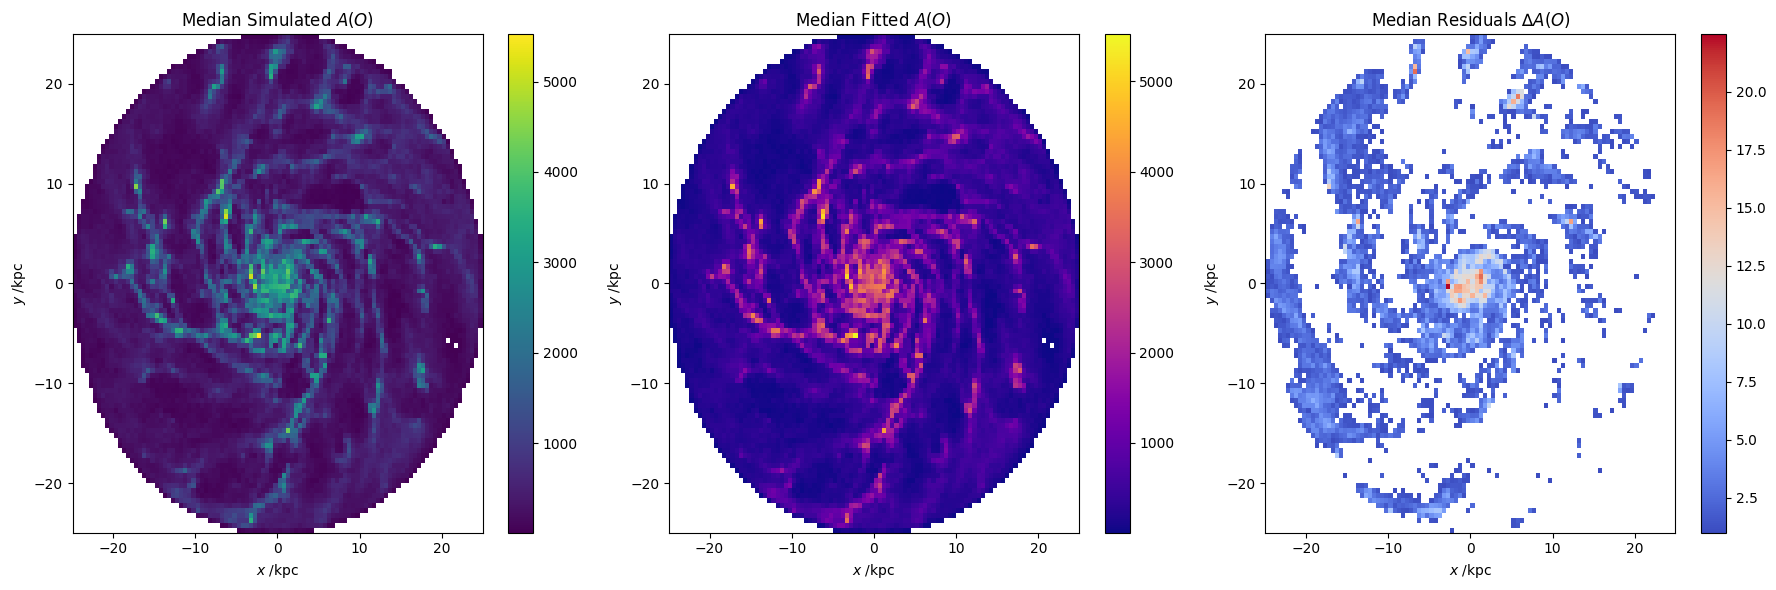

In [11]:
import matplotlib.pyplot as plt

# Creating a 3-panel figure for the x vs. y plane
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot (a): 2D-histogram of the median simulated A(O)
h1 = ax[0].hist2d(x, y, bins=100, weights=A_O, cmap='viridis', cmin=1)
fig.colorbar(h1[3], ax=ax[0])  # Adding a color bar
ax[0].set_title(r'Median Simulated $A(O)$')
ax[0].set_xlabel(r'$x$ /kpc')
ax[0].set_ylabel(r'$y$ /kpc')

# Plot (b): 2D-histogram of the median fitted A(O)
h2 = ax[1].hist2d(x, y, bins=100, weights=A_O_fit, cmap='plasma', cmin=1)
fig.colorbar(h2[3], ax=ax[1])
ax[1].set_title(r'Median Fitted $A(O)$')
ax[1].set_xlabel(r'$x$ /kpc')
ax[1].set_ylabel(r'$y$ /kpc')

# Plot (c): 2D-histogram of the median residuals ∆A(O)
h3 = ax[2].hist2d(x, y, bins=100, weights=A_O_residuals, cmap='coolwarm', cmin=1)
fig.colorbar(h3[3], ax=ax[2])
ax[2].set_title(r'Median Residuals ∆$A(O)$')
ax[2].set_xlabel(r'$x$ /kpc')
ax[2].set_ylabel(r'$y$ /kpc')

# Saving the figure as figures/median_histograms.png
plt.tight_layout()
plt.savefig('figures/median_histograms.png', dpi=200)
plt.show()

* Describe your choice of 2D bins. Discuss what details would be missed with fewer bins or problems encountered with more bins.

Using 100 bins gives us a relatively fine resolution, allowing us to capture variations in the metallicity distributions across the plane. It helps in visualizing both large-scale trends and small-scale fluctuations in the simulated and fitted data, as well as the residuals. 50 bins are a moderate number, which balances the need for detail without making the plot computationally expensive to generate. More bins would increase the processing time and potentially lead to memory issues with very large datasets. At 100 bins, the plot is not overcrowded, and the bins are small enough to prevent "blocky" patterns in the histograms. This choice avoids making the data appear overly pixelated while still maintaining smooth gradients and transitions.

#### Effects of Using Fewer or More Bins:

1. **Fewer Bins** (e.g., 50 or fewer):
    - **Coarser Resolution**: With fewer bins, small-scale details, such as localized variations in metallicity, would be missed. This would smooth out the fine structures, leading to the loss of potentially important features, such as small clusters of high or low metallicity regions.
    - **Over-smoothing**: A reduced number of bins would create an overly generalized view of the data, obscuring subtle differences between the simulated and fitted metallicity and hiding regions where the residuals are large. This could lead to inaccurate conclusions regarding the linear fit's performance in specific regions.

2. **More Bins** (e.g., 200 or more):
    - **Over-fragmentation**: With more bins, the plot would break down the data into many small sections, which could make the visual interpretation more difficult. Too many bins might introduce noise, especially if there are not enough data points to fill each bin, leading to sparsity and potentially misleading empty or zero-value bins.
    - **Computation and Memory Overhead**: A higher number of bins increases the computational cost and memory usage, particularly for large datasets. This could slow down the plot generation process and cause performance issues, especially when working with large-scale simulations.

### Conclusion:
The choice of **100 bins** represents a compromise between sufficient detail, computational efficiency, and visual clarity. Fewer bins would result in missed details, especially at smaller scales, while more bins could introduce noise and unnecessary computational complexity. By selecting 100 bins, we achieve a good balance for effective analysis of the radial metallicity relation in the x vs. y plane.

* Analyze the residuals in more detail and propose an explanation for any patterns you observe.

### Analysis of the Residuals in Detail:

The residuals ($\Delta A(O)$) represent the difference between the simulated gas phase metallicity ($A(O)$) and the linear fit across the galactocentric radius $R_{\text{Gal}}$. Analyzing these residuals can help us identify regions where the linear model fails to capture the true variation in metallicity and suggest possible astrophysical or simulation-related explanations for these deviations.

#### 1. **Residuals vs. Galactocentric Radius $ R_{\text{Gal}} $:**
   - **Trend**: From the residual plot, we observe systematic deviations at certain radii. The residuals increase as we move away from the center of the galaxy (higher $R_{\text{Gal}}$).
       - **Central/Inner regions** (small $R_{\text{Gal}}$): The residuals may show a bias, indicating that the linear model systematically under- or over-predicts metallicities close to the galactic center.
       - **Outer regions** (larger $R_{\text{Gal}}$): Similarly, the residuals might indicate that the fit is worse at the outskirts, where star formation and accretion of metal-poor gas might lead to deviations from a simple linear trend.
   - **Explanation**: In real galaxies, the inside-out formation model suggests that the central regions of galaxies are more metal-rich due to earlier and more intense star formation, while the outer regions experience gas inflow and star formation at later stages, often resulting in lower metallicity. This complex evolutionary process might not be captured by a simple linear fit, leading to larger residuals in certain radial ranges.
     - **Central/Inner regions** (small $R_{\text{Gal}}$): Higher star formation rates and gas outflows could lead to more complex metallicity distributions, which are not well captured by a simple linear fit. In these regions, feedback processes might inject metals into the surrounding medium, leading to enhanced metallicity that deviates from the model.
     - **Outer regions** (large $R_{\text{Gal}}$): The outer parts of the galaxy are subject to accretion of metal-poor gas from the intergalactic medium, leading to a flattening of the metallicity gradient. This would cause the linear model to overestimate the metallicity in these regions, creating large positive residuals.

#### 2. **Residuals in the $x$ vs. $y$ Plane:**
   - **Patterns**: When visualizing the residuals across the x vs. y plane (from the 3-panel plot), we observe specific spatial patterns in the distribution of residuals:
       - **Localized regions** of high or low residuals might correspond to particular substructures in the galaxy, such as spiral arms, star-forming regions, or areas influenced by feedback from supernovae or active galactic nuclei (AGN).
       - **Symmetry**: If there is any symmetry in the residuals, such as radial or azimuthal symmetry, it could suggest that certain radial or angular processes dominate the metallicity distribution.
   - **Explanation**: Spatial variations in the residuals could be due to inhomogeneities in the distribution of gas and metals, driven by processes such as:
        - **Radial migration**: Stars and gas may move outward or inward, carrying metals with them and creating deviations from the expected radial gradient.
        - **Gas inflows and outflows**: Metal-poor gas inflows from the halo or metal-enriched gas outflows due to feedback mechanisms could cause localized deviations from the overall trend.
        - **Star formation and feedback**: Regions of active star formation or supernova feedback could enrich the surrounding medium with metals, leading to local increases in metallicity not captured by the linear model.

### Conclusion:

The residuals reveal important insights into where the linear model fails to describe the complex radial metallicity gradient. The non-linear nature of the gradient, feedback processes, and gas inflows/outflows all contribute to the observed patterns. Further modeling could involve fitting a non-linear model or applying a more sophisticated method that accounts for these astrophysical processes, providing a better representation of the metallicity distribution.